In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    mean_absolute_error, 
    mean_squared_error,
    confusion_matrix
)

# Function to evaluate the model and print metrics
def evaluate_model(model_name, model, test_generator):
    # Reset the generator to start from the beginning
    test_generator.reset()  
    
    # Get predictions
    y_pred_prob = model.predict(test_generator)
    y_pred = np.argmax(y_pred_prob, axis=1)  # Use argmax for multi-class predictions
    y_true = test_generator.classes  # True labels

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')  # Weighted for multi-class
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    auc = roc_auc_score(y_true, y_pred_prob, multi_class='ovr')  # Multi-class ROC AUC

    # Print metrics
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Root Mean Square Error: {rmse:.4f}")
    print(f"AUC Score: {auc:.4f}\n")

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Benign', 'Malignant', 'Normal'],
                yticklabels=['Benign', 'Malignant', 'Normal'])
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.savefig(f'Confusion_{model_name}.png', format='png', dpi=600, bbox_inches="tight")
    plt.show()

In [5]:
import os 
import numpy as np
import cv2  # OpenCV for general use (not CLAHE)
import tensorflow as tf
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121
from sklearn.utils.class_weight import compute_class_weight

# Define paths
dataset_path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
base_dir = '/kaggle/working/split_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Ensure clean split directories
for dir_path in [train_dir, val_dir, test_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)

# Split dataset into 70% train, 20% test, 10% validation
all_images = []
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]
    all_images.extend([(img, class_name) for img in images])

test_split = 0.2
val_split = 0.1
train_images, temp_images = train_test_split(
    all_images,
    test_size=(test_split + val_split),
    stratify=[label for _, label in all_images],
    random_state=42
)
val_images, test_images = train_test_split(
    temp_images,
    test_size=(test_split / (test_split + val_split)),
    stratify=[label for _, label in temp_images],
    random_state=42
)

# Copy files into respective directories without preprocessing
def copy_images(images, target_dir):
    for img_path, label in images:
        label_dir = os.path.join(target_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy(img_path, label_dir)  # Copy the original image without preprocessing

copy_images(train_images, train_dir)
copy_images(val_images, val_dir)
copy_images(test_images, test_dir)

# Parameters
input_shape = (128, 128, 3)
batch_size = 32
epochs = 20

# Create data generators for binary classification
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'  # Binary classification
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'  # Binary classification
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',  # Binary classification
    shuffle=False
)

# Print the number of samples in each split
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")

# Compute class weights
train_labels = train_generator.classes  # Class indices for training samples
class_names = list(train_generator.class_indices.keys())
class_weights = compute_class_weight(
    class_weight='balanced',  # Balance classes based on their frequency
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))

# Print the calculated class weights
print("Class Weights:", class_weights)

# Load pre-trained DenseNet121 model + higher-level layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)  # Binary classification

# Create the complete model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with class weights
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights  # Use calculated class weights
)

# Unfreeze the base model for fine-tuning
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])  # Reduce learning rate for fine-tuning

# Fine-tune the model with class weights
history_fine = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights
)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator)
print('Loss:', loss)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Found 1104 images belonging to 3 classes.
Found 158 images belonging to 3 classes.
Found 316 images belonging to 3 classes.
Training samples: 1104
Validation samples: 158
Test samples: 316
Class Weights: {0: 0.5906902086677368, 1: 1.2474576271186442, 2: 1.978494623655914}
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/35 ━━━━━━━━━━━━━━━━━━━━ 43s 676ms/step - accuracy: 0.5389 - loss: 1.3649 - val_accuracy: 0.7405 - val_loss: 0.4958
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 211ms/step - accuracy: 0.7325 - loss: 0.5540 - val_accuracy: 0.8354 - val_loss: 0.3819
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 213ms/step - accuracy: 0.7750 - loss: 0.4806 - val_accuracy: 0.8101 - val_loss: 0.4141
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 213ms/step - accuracy: 0.7791 - loss: 0.5227 - val_accuracy: 0.8418 - val_loss: 0.3687
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 211ms/step - accuracy: 0.8018 - loss: 0.4404 - val_accuracy: 0.8228 - val_loss: 0.4002
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 211ms/step - accuracy: 0.8045 - loss: 0.4429 - val_accuracy: 0.8418 - val_loss: 0.3916
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 214ms/step - accuracy: 0.7855 - loss: 0.4624 - val_accuracy: 0.8608 - val_loss: 0.3420
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 210ms/step - accuracy: 0.8297 - loss: 0.4248 - val_accuracy: 0.8354 - val

10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 812ms/step
Model: DNBCD
Accuracy: 0.8861
Precision: 0.8984
Recall: 0.8861
F1 Score: 0.8877
Mean Absolute Error: 0.1614
Root Mean Square Error: 0.5063
AUC Score: 0.9669



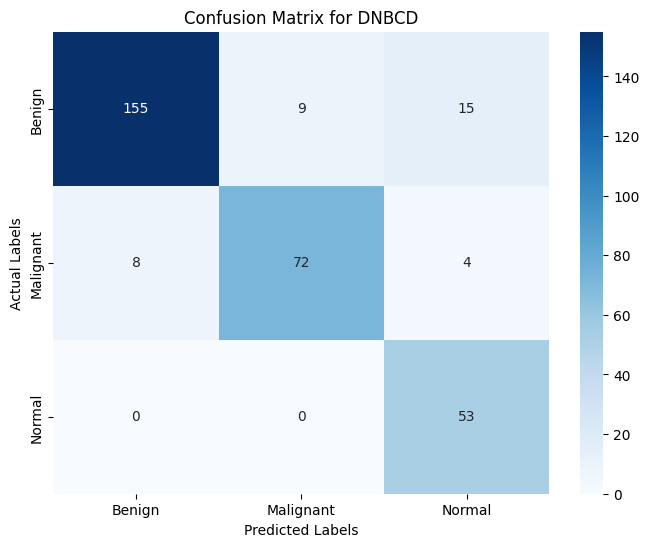

In [6]:
model_name= "DNBCD"
evaluate_model(model_name,model, test_generator)

In [1]:
import os 
import numpy as np
import cv2  # OpenCV for general use (not CLAHE)
import tensorflow as tf
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121
from sklearn.utils.class_weight import compute_class_weight

# Define paths
dataset_path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
base_dir = '/kaggle/working/split_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Ensure clean split directories
for dir_path in [train_dir, val_dir, test_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)

# Split dataset into 70% train, 20% test, 10% validation
all_images = []
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]
    all_images.extend([(img, class_name) for img in images])

test_split = 0.2
val_split = 0.1
train_images, temp_images = train_test_split(
    all_images,
    test_size=(test_split + val_split),
    stratify=[label for _, label in all_images],
    random_state=42
)
val_images, test_images = train_test_split(
    temp_images,
    test_size=(test_split / (test_split + val_split)),
    stratify=[label for _, label in temp_images],
    random_state=42
)

# Copy files into respective directories without preprocessing
def copy_images(images, target_dir):
    for img_path, label in images:
        label_dir = os.path.join(target_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy(img_path, label_dir)  # Copy the original image without preprocessing

copy_images(train_images, train_dir)
copy_images(val_images, val_dir)
copy_images(test_images, test_dir)

# Parameters
input_shape = (128, 128, 3)
batch_size = 32
epochs = 20

# Create data generators for binary classification
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'  # Binary classification
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'  # Binary classification
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',  # Binary classification
    shuffle=False
)

# Print the number of samples in each split
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")

# Compute class weights
train_labels = train_generator.classes  # Class indices for training samples
class_names = list(train_generator.class_indices.keys())
class_weights = compute_class_weight(
    class_weight='balanced',  # Balance classes based on their frequency
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))

# Print the calculated class weights
print("Class Weights:", class_weights)

# Load pre-trained DenseNet121 model + higher-level layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)  # Binary classification

# Create the complete model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with class weights
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights  # Use calculated class weights
)

# Unfreeze the base model for fine-tuning
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])  # Reduce learning rate for fine-tuning

# Fine-tune the model with class weights
history_fine = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights
)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator)
print('Loss:', loss)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Found 1104 images belonging to 3 classes.
Found 158 images belonging to 3 classes.
Found 316 images belonging to 3 classes.
Training samples: 1104
Validation samples: 158
Test samples: 316
Class Weights: {0: 0.5906902086677368, 1: 1.2474576271186442, 2: 1.978494623655914}
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/35 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.5406 - loss: 1.2441 - val_accuracy: 0.7089 - val_loss: 0.5636
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.6866 - loss: 0.7526 - val_accuracy: 0.7215 - val_loss: 0.5364
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 37s 986ms/step - accuracy: 0.7220 - loss: 0.6169 - val_accuracy: 0.7152 - val_loss: 0.5227
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 37s 991ms/step - accuracy: 0.7162 - loss: 0.6253 - val_accuracy: 0.7595 - val_loss: 0.4770
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7518 - loss: 0.5188 - val_accuracy: 0.7342 - val_loss: 0.4786
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.7690 - loss: 0.4917 - val_accuracy: 0.8228 - val_loss: 0.4169
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 36s 970ms/step - accuracy: 0.7671 - loss: 0.5375 - val_accuracy: 0.7468 - val_loss: 0.4470
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.7938 - loss: 0.4846 - val_accuracy: 0.7911 - val_loss: 0

10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step 
Model: DNBCD
Accuracy: 0.9114
Precision: 0.9117
Recall: 0.9114
F1 Score: 0.9111
Mean Absolute Error: 0.1076
Root Mean Square Error: 0.3815
AUC Score: 0.9767



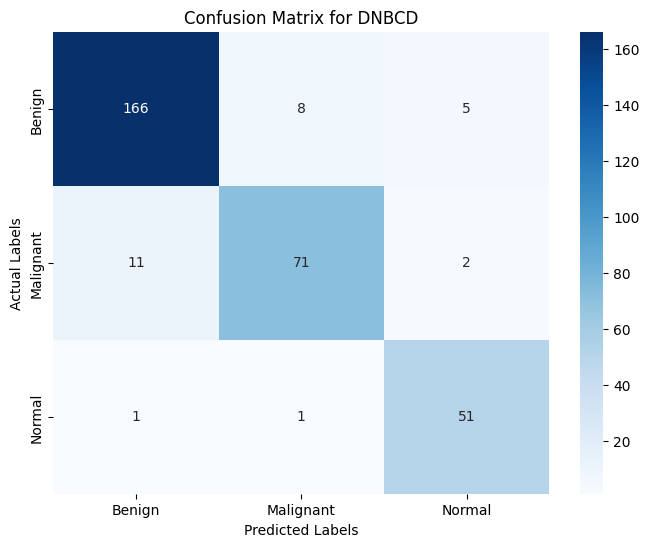

In [4]:
model_name= "DNBCD"
evaluate_model(model_name,model, test_generator)